In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from scipy.constants import c

from scipy.optimize import curve_fit
from datetime import datetime

#%matplotlib qt

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
f_carrier = 2216499165.732132
f_tx = (221*f_carrier) / 240
print (f_tx)

2041026315.1116714


In [3]:
data = np.fromfile('/media/scott/fast/data/20221116/art1_postTCM1.dat', sep = ' ').reshape((-1,4))
t_data = Time(data[:,0], format = 'mjd')
freq_data = data[:,1]
int_data = data[:,2]

In [4]:
gmd_file = '/home/scott/code/GMAT/R2020a/output/Artemis1_Doppler.gmd'
gmd_mjd = []
gmd_rangerate = []
with open(gmd_file) as f:
    for l in f.readlines()[2:]:
        gmd_mjd.append(float(l.split()[0]))
        gmd_rangerate.append(float(l.split()[-1]))
gmd_mjd = np.array(gmd_mjd)
gmd_rangerate = np.array(gmd_rangerate)
t_gmd = Time(gmd_mjd + (2430000.0 - 2400000.5), scale = 'tai', format = 'mjd')

In [5]:
rangerate_interp = np.interp(t_data.utc.mjd, t_gmd.utc.mjd, gmd_rangerate)
freq_gmat = f_carrier * (1 - 1e3*rangerate_interp/c)

freq_diff = freq_data - freq_gmat
np_diff = np.array(freq_diff)

In [6]:
x = 0
count = t_data.shape[0]
t_zero = (data[0,0] - int(data[0,0])) * 86400
np_t = [0.0] * count

for x in range (0,count):
    np_t[x] = ((data[x,0] - int(data[0,0])) * 86400) - t_zero

np_t = np.array(np_t)



In [7]:
#Find corrected carrier

m, b = np.polyfit(np_t, np_diff,1)
corrected_carrier = f_carrier + np.mean(np_diff)

last_carrier = corrected_carrier

while True:
    freq_gmat = corrected_carrier * (1 - 1e3*rangerate_interp/c)
    freq_diff = freq_data - freq_gmat
    np_diff = np.array(freq_diff)
    m, b = np.polyfit(np_t, np_diff,1)
    corrected_carrier = last_carrier + np.mean(np_diff)
    print(corrected_carrier)
    diff_carrier = last_carrier - corrected_carrier
    print(diff_carrier)
    last_carrier = corrected_carrier
    if diff_carrier < 0:
        diff_carrier = diff_carrier * -1
    if (diff_carrier < 0.000001):
        break

2216499188.279537
-0.0001697540283203125
2216499188.279537
0.0


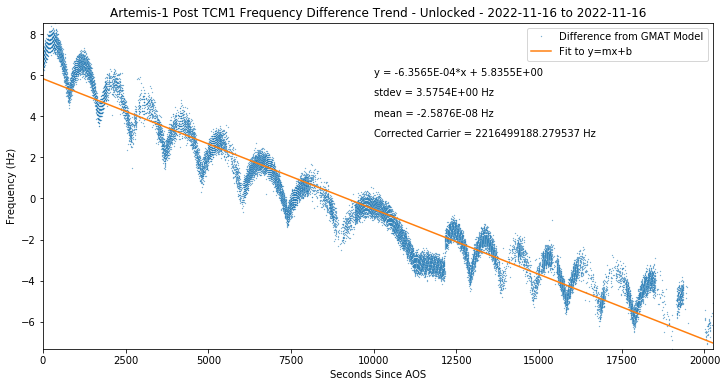

In [12]:
upper = np.max(np_diff)
lower = np.min(np_diff)

plt.ylim(np.mean(np_diff)+lower, np.mean(np_diff)+upper)
plt.xlim(0,max(np_t))
plt.plot(np_t, freq_diff, '.',markersize=.5, label = 'Difference from GMAT Model')
plt.plot(np_t, m*np_t + b, label = 'Fit to y=mx+b')
plt.text(10000,np.mean(np_diff)+6, 'y = %.4E*x + %.4E'%(m,b))
plt.text(10000,np.mean(np_diff)+5, 'stdev = %.4E Hz'%np.std(np_diff))
plt.text(10000,np.mean(np_diff)+4, 'mean = %.4E Hz'%np.mean(np_diff))
plt.text(10000,np.mean(np_diff)+3, 'Corrected Carrier = %.6f Hz'%corrected_carrier)
plt.title('Artemis-1 Post TCM1 Frequency Difference Trend - Unlocked - %s to %s'%(t_data.datetime[0].strftime('%Y-%m-%d'), t_data.datetime[len(freq_diff)-1].strftime('%Y-%m-%d')))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Seconds Since AOS')
plt.legend()
plt.show();


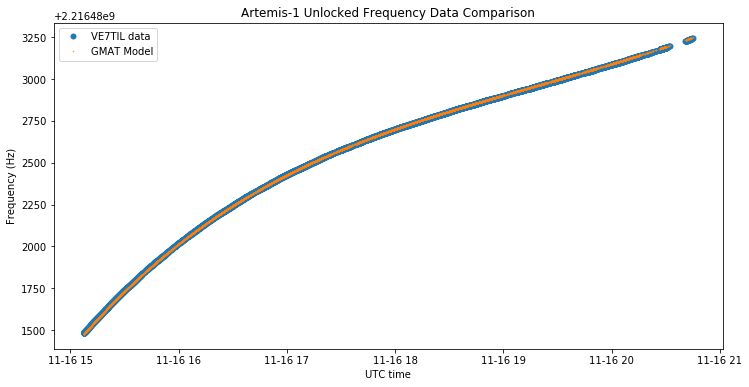

In [9]:
plt.plot(t_data.datetime,freq_data,'.' ,markersize=10, alpha=2, label = 'VE7TIL data')
plt.plot(t_data.datetime, freq_gmat, '.',markersize=1,alpha=1,label = 'GMAT Model')
plt.title('Artemis-1 Unlocked Frequency Data Comparison')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.legend()
plt.show();

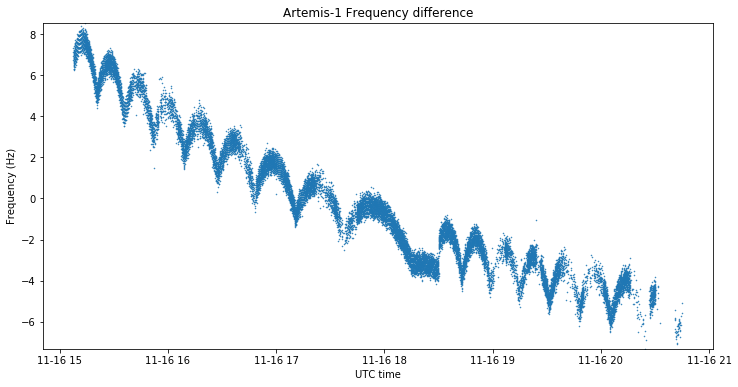

In [10]:
plt.ylim(np.min(np_diff), np.max(np_diff))
plt.plot(t_data.datetime, freq_data - freq_gmat,'.', markersize=1, label = 'strf file')
plt.title('Artemis-1 Frequency difference')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.show()